# Training Notebook for BirdCLEF2023

## Import all dependencies

In [128]:
import torch
import torchvision
import torchaudio
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import timm
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import os
import sys
import random
import time
import copy
import logging
import bisect

## Define a CONFIG class containing all relevant hyperparameters

In [129]:
### DO NOT CHANGE UNLESS RE-GENERATING DATASET IMAGES ###
class Config_Mel():
    def __init__(self) -> None:
        
        # Device
        self.device = 'cpu'
        
        # Dataset Path
        self.birdclef2023 = 'birdclef-2023'

        # Out path
        self.outpath_images = self.birdclef2023 + '_MelSpectrograms'

        self.melSpecTransform = torchaudio.transforms.AmplitudeToDB()

        # Audio Features
        self.sample_rate = 32000
        self.n_fft=2048
        self.f_min=40
        self.f_max=15000
        self.hop_length=512
        self.n_mels=128
        self.mel_args = {'sample_rate': self.sample_rate,
                         'n_fft': self.n_fft,
                         'f_min': self.f_min,
                         'f_max': self.f_max,
                         'hop_length': self.hop_length,
                         'n_mels': self.n_mels}
### DO NOT CHANGE UNLESS RE-GENERATING DATASET IMAGES ###

class Config():
    def __init__(self) -> None:

        self.kaggle = False
        self.rerun_split = False

        # Device
        if self.kaggle == True:
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        
        # Dataset Path
        self.birdclef2023 = 'birdclef-2023'
        if self.kaggle == True:
            self.birdclef2023_melspectrograms = '/kaggle/input/birdclef-2023-melspectrograms/birdclef-2023_MelSpectrograms'
        else:
            self.birdclef2023_melspectrograms = '/home/colin/elec5305/ele5305_research_project/birdclef-2023_MelSpectrograms'

        # Out path
        if self.kaggle == True:
            self.outpath = '/kaggle/working/results'
        else:
            self.outpath = 'results'

        # Train/Validation Split 
        self.val_frac = 0.1

        # Dataloader options
        self.num_workers = 2
        self.train_batch_size = 64
        self.valid_batch_size = 64

        # Model name
        self.model_name = 'tf_efficientnet_b0_ns'


        # Optimizer Settings
        self.lr=0.0004
        self.momentum=0.9
        self.criterion = nn.BCEWithLogitsLoss
        self.optimizer = torch.optim.SGD
        self.scheduler = None

        # Training Settings
        self.epochs = 10
        self.print_every_n_batches = 25
        self.patience = 3
        self.fix_features = False

        # Image Transforms
        self.train_transforms = torchvision.transforms.Compose([
                    transforms.ToTensor(),
                    torchvision.transforms.RandomResizedCrop(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])
        
        self.val_transforms = torchvision.transforms.Compose([
                    transforms.ToTensor(),
                    torchvision.transforms.Resize(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])
        
        self.test_transforms = torchvision.transforms.Compose([
                    transforms.ToTensor(),
                    torchvision.transforms.Resize(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])

        # Audio Transforms
        self.train_transforms_audio = None
        
        self.val_transforms_audio = None
        
        self.test_transforms_audio = None


        # Audio Features
        self.sample_rate = 32000
        self.period = 5

        # Mel Spectrogram Parameters
        self.n_fft=2048
        self.f_min=40
        self.f_max=15000
        self.hop_length=512
        self.n_mels=128
        self.mel_args = {'n_fft': self.n_fft,
                         'f_min': self.f_min,
                         'f_max': self.f_max,
                         'hop_length': self.hop_length,
                         'n_mels': self.n_mels}
        
CONFIG = Config()

## Define Network

In [130]:
class Mel_Classifier(torch.nn.Module):
    def __init__(self, model_name, num_classes = 264, pretrained = True):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )

    def forward(self,x):
        x = self.backbone(x)
        return x

## Create a Dataloader Class

In [131]:
class BirdCLEF2023_MelSpec_Dataset(torch.nn.Module):
    def __init__(self, dataset_path, train_flag = None, *args, **kwargs) -> None:

        # Default values
        self.sample_rate = kwargs.get('sample_rate', 32000)
        self.n_fft = kwargs.get('n_fft', 2048)
        self.f_min = kwargs.get('f_min', 40)
        self.f_max = kwargs.get('f_max', 15000)
        self.hop_length = kwargs.get('hop_length', 512)
        self.n_mels = kwargs.get('n_mels', 128)
        self.period = kwargs.get('period', 5)
        self.device = kwargs.get('device', 'cpu')
        self.transform = kwargs.get('transform', transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]))
         
        # Save path of dataset
        self.datapath = dataset_path

        # Get metadata
        if train_flag is None:
            csv_name = 'train_metadata.csv'
        elif train_flag == 'train':
            csv_name = 'TRAIN_train_metadata.csv'
        elif train_flag == 'valid':
            csv_name = 'VALID_train_metadata.csv'

        self.df = pd.read_csv(os.path.join(dataset_path, csv_name))

        # Get species list
        self.species = list(set(self.df['primary_label']))

        # Get time per pixel
        self.time_per_pixel = self.hop_length / self.sample_rate

        # Image Width
        self.new_width = int(self.period / self.time_per_pixel)

        # Get number of cut images per full image
        self.get_shortened_image()
        
        return
    
    def get_shortened_image(self):

        old_len = len(list(self.df['primary_label']))
        number_of_images_per_image = [0] * old_len

        cumulative_images_count = 0
        cumulative_list = [0] * old_len

        for i in range(old_len):
            dict_idx = dict(self.df.iloc[i])

            # Load image
            rel_img_path = dict_idx['image_path']
            ful_img_path = os.path.join(self.datapath,rel_img_path)
            image = Image.open(ful_img_path)

            # Get image shape
            width, height = image.size

            # How many images of self.period length fit in image?
            n_imgs = width // self.new_width

            # Put to list
            number_of_images_per_image[i] = n_imgs

            # Calculate the cumulative count
            cumulative_images_count += n_imgs

            # Put to list
            cumulative_list[i] = cumulative_images_count - 1


        # Add number_of_images_per_image as a new column to the DataFrame
        self.df['cumulative_images'] = cumulative_list


        return
    
    def __len__(self):
        # length = self.df['cumulative_images'][-1]
        length = self.df['cumulative_images'].iloc[-1]
        return length

    def __getitem__(self, idx):

        # Get the 'cumulative_list' values as a sorted list
        cumulative_list_values = self.df['cumulative_images'].tolist()

        # Use binary search to find the index of the next smallest value to idx
        row_index = bisect.bisect_left(cumulative_list_values, idx)
        cumulative_value_left = 0
        if row_index == 0:
            cumulative_value_left = 0
        else:
            cumulative_value_left = self.df['cumulative_images'].iloc[row_index-1] + 1
        sub_idx = idx - cumulative_value_left

        # Get row in df
        dict_idx = dict(self.df.iloc[row_index])

        # Calculate image crop start pixel based on sub_idx
        px_start = sub_idx * self.new_width

        # Get labels as torch tensors
        primary_label = torch.tensor([1 if dict_idx['primary_label'] == label else 0 for label in self.species],dtype=float)
        secondary_label = torch.tensor([1 if label in dict_idx['secondary_labels'] else 0 for label in self.species], dtype=float)
        combined_label = self._prepare_target(main_tgt=primary_label, sec_tgt=secondary_label)
        dict_idx['combined_label_tensor'] = combined_label
        dict_idx['primary_label_tensor'] = primary_label
        dict_idx['secondary_label_tensor'] = secondary_label

        # Load image
        rel_img_path = dict_idx['image_path']
        ful_img_path = os.path.join(self.datapath,rel_img_path)
        image = Image.open(ful_img_path)
        image = self.crop_image(image = image, startPixel = px_start)
        if self.transform is not None:
            image = self.transform(image)
        dict_idx['mel_spec'] = image
    
        return dict_idx
    
    def crop_image(self, image, startPixel):
        image = image.crop((startPixel, 0, startPixel + self.new_width, image.height))
        return image

    # https://github.com/VSydorskyy/BirdCLEF_2023_1st_place/blob/main/code_base/datasets/wave_dataset.py, changed
    def _prepare_target(self, main_tgt, sec_tgt, all_labels=None):
        all_tgt = main_tgt + sec_tgt
        all_tgt = torch.clamp(all_tgt, 0.0, 1.0)
        return all_tgt

## Create a Training/Validation Split Scheme

In [132]:
# https://www.kaggle.com/code/nischaydnk/split-creating-melspecs-stage-1
def birds_stratified_split(df, target_col, test_size=0.2):
    class_counts = df[target_col].value_counts()
    low_count_classes = class_counts[class_counts < 2].index.tolist() ### Birds with single counts

    df['train'] = df[target_col].isin(low_count_classes)

    train_df, val_df = train_test_split(df[~df['train']], test_size=test_size, stratify=df[~df['train']][target_col], random_state=42)

    train_df = pd.concat([train_df, df[df['train']]], axis=0).reset_index(drop=True)

    # Remove the 'valid' column
    train_df.drop('train', axis=1, inplace=True)
    val_df.drop('train', axis=1, inplace=True)

    return train_df, val_df

def save_df_as_csv(df, csv_name):
    df.to_csv(csv_name, index=False)
    return

def create_split_and_save(df_path, val_frac):

    # Load dataframe
    df = pd.read_csv(os.path.join(df_path, 'train_metadata.csv'))

    # Get Split
    train_df, val_df = birds_stratified_split(df=df, target_col='primary_label', test_size=val_frac)

    # Save metadata
    os.path.join(df_path, 'TRAIN_train_metadata.csv')
    save_df_as_csv(train_df, os.path.join(df_path, 'TRAIN_train_metadata.csv'))
    save_df_as_csv(val_df, os.path.join(df_path, 'VALID_train_metadata.csv'))

    return

In [133]:
if CONFIG.rerun_split == True:
    create_split_and_save(df_path=CONFIG.birdclef2023_melspectrograms, val_frac=CONFIG.val_frac)

## Make Datasets and Dataloaders

In [134]:
train_class_kwargs = {  'sample_rate': CONFIG.sample_rate,
                        'n_fft': CONFIG.n_fft,
                        'f_min': CONFIG.f_min,
                        'f_max': CONFIG.f_max,
                        'hop_length': CONFIG.hop_length,
                        'n_mels': CONFIG.n_mels,
                        'period': CONFIG.period,
                        'device': CONFIG.device,
                        'transforms': CONFIG.train_transforms
                     }

valid_class_kwargs = {   'sample_rate': CONFIG.sample_rate,
                        'n_fft': CONFIG.n_fft,
                        'f_min': CONFIG.f_min,
                        'f_max': CONFIG.f_max,
                        'hop_length': CONFIG.hop_length,
                        'n_mels': CONFIG.n_mels,
                        'period': CONFIG.period,
                        'device': CONFIG.device,
                        'transforms': CONFIG.val_transforms
                    }

train_dataset = BirdCLEF2023_MelSpec_Dataset(CONFIG.birdclef2023_melspectrograms, **train_class_kwargs, train_flag='train')
valid_dataset = BirdCLEF2023_MelSpec_Dataset(CONFIG.birdclef2023_melspectrograms, **valid_class_kwargs, train_flag='valid')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,num_workers=CONFIG.num_workers, batch_size=CONFIG.train_batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,num_workers=CONFIG.num_workers, batch_size=CONFIG.valid_batch_size, shuffle = True)

### Visualize some spectrograms

In [135]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        dict_idx = img_ds[img_index]        
        img, lb = dict_idx['mel_spec'], dict_idx['primary_label']      
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

2023-10-31 17:08:09,485 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-10-31 17:08:09,485 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-10-31 17:08:09,548 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-10-31 17:08:09,548 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-10-31 17:08:09,720 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-10-31 17:08:09,720 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-10-31

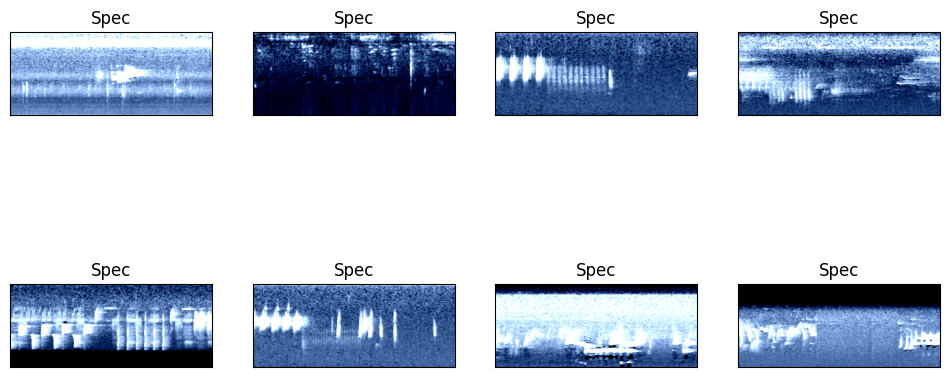

In [136]:
show_batch(train_dataset, 8, 2, 4)

## Define Training Function

In [137]:
def create_logger(final_output_path):
    log_file = '{}.log'.format(time.strftime('%Y-%m-%d-%H-%M'))
    head = '%(asctime)-15s %(message)s'
    logging.basicConfig(filename=os.path.join(final_output_path, log_file),
                        format=head)
    clogger = logging.getLogger()
    clogger.setLevel(logging.INFO)
    # add handler
    # print to stdout and log file
    ch = logging.StreamHandler(sys.stdout)
    ch.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    clogger.addHandler(ch)
    return clogger

def train_net(net, trainloader, valloader, logging, criterion, optimizer, scheduler, epochs=1, patience = 3, savePth = 'project2_weights.pth', print_every_samples = 20, device = 'cpu'):

    logging.info('Using device: {}'.format(device))
    net.to(device)

    validation_loss_list = []
    training_loss_list = []
    validation_accuracy_list = []
    training_accuracy_list = []

    best_state_dictionary = None
    best_validation_accuracy = 0.0
    inertia = 0
    for epoch in tqdm(range(epochs), desc="Epochs"):

        training_loss = 0.0
        training_accuracy = 0.0
        running_loss = 0.0
        net = net.train()
        with tqdm(enumerate(trainloader, 0), total=len(trainloader), desc="Training Batches") as train_pbar:
            for i, data in train_pbar:
                # get the inputs
                inputs, labels = data['mel_spec'], data['primary_label_tensor']
                if device == 'cuda':
                    inputs, labels = inputs.cuda(), labels.cuda()
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                if device == 'cuda':
                    loss = loss.cpu()

                # print statistics and write to log
                running_loss += loss.item()
                training_loss += loss.item()
                if i % print_every_samples == print_every_samples - 1:    # print every 2000 mini-batches
                    logging.info('[%d, %5d / %5d] Training loss: %.3f' %
                        (epoch + 1, i + 1, len(trainloader), running_loss / print_every_samples))
                    running_loss = 0.0

                training_accuracy += (outputs.argmax(1) == labels.argmax(1)).sum().item()

        if type(scheduler).__name__ != 'NoneType':
            scheduler.step()

        training_loss = training_loss / len(trainloader.dataset)
        training_loss_list.append(training_loss)
        training_accuracy = 100 * training_accuracy / len(trainloader.dataset)
        training_accuracy_list.append(training_accuracy)

        running_loss = 0.0
        val_loss = 0.0
        correct = 0
        net = net.eval()
        with tqdm(enumerate(valloader, 0), total=len(valloader), desc="Validation Batches") as val_pbar:
            for i, data in val_pbar:
                # get the inputs
                inputs, labels = data['mel_spec'], data['primary_label_tensor']
                if device == 'cuda':
                    inputs, labels = inputs.cuda(), labels.cuda()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                if device == 'cuda':
                    loss = loss.cpu()

                # print statistics and write to log
                running_loss += loss.item()
                val_loss += loss.item()
                if i % print_every_samples == print_every_samples - 1:  # print every 2000 mini-batches
                    logging.info('[%d, %5d / %5d] Validation loss: %.3f' %
                                (epoch + 1, i + 1, len(valloader), running_loss / print_every_samples))
                    running_loss = 0.0
                correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()

        val_loss = val_loss / len(valloader.dataset)
        validation_loss_list.append(val_loss)
        val_accuracy = 100 * correct / len(valloader.dataset)
        validation_accuracy_list.append(val_accuracy)

        save_weights = os.path.join(savePth,'model_weights.pth')
        if val_accuracy > best_validation_accuracy:
            best_state_dictionary = copy.deepcopy(net.state_dict())
            # save network
            torch.save(best_state_dictionary, save_weights)
            inertia = 0
        else:
            inertia += 1
            if inertia == patience:
                if best_state_dictionary is None:
                    raise Exception("State dictionary should have been updated at least once")
                break
        print(f"Validation accuracy: {val_accuracy}")

    logging.info('Finished Training')

    output = {'validation_loss': validation_loss_list,
              'validation_accuracy': validation_accuracy_list,
              'training_loss': training_loss_list,
              'training_accuracy': training_accuracy_list}
    
    return output

## Run Training Procedure

In [138]:
def main_train():
    # Load Config
    CONFIG = Config()

    # Change Output path
    folder_name = time.strftime('%Y-%m-%d_%H-%M-%S')
    outpath = os.path.join(CONFIG.outpath, folder_name)
    CONFIG.outpath = outpath
    # Create Output directory
    os.makedirs(CONFIG.outpath, exist_ok=True)

    # Create Logger
    logger = create_logger(final_output_path=CONFIG.outpath)

    # Get all variable to logger
    logger.info('############################################ START CONFIG FILE ############################################')
    for attr, value in vars(CONFIG).items():
        logger.info(f"{attr}: {value}")
    logger.info('############################################  END CONFIG FILE  ############################################')

    network = Mel_Classifier(model_name=CONFIG.model_name)

    if CONFIG.fix_features == True:
        for param in network.backbone.parameters():
            param.requires_grad = False

    criterion = CONFIG.criterion()
    optimizer = CONFIG.optimizer(filter(lambda p: p.requires_grad, network.parameters()), lr=CONFIG.lr, momentum=CONFIG.momentum)
    scheduler = CONFIG.scheduler

    train_net(net=network,
              trainloader=train_loader,
              valloader=valid_loader,
              criterion=criterion,
              optimizer=optimizer,
              logging=logger,
              scheduler=scheduler,
              epochs=CONFIG.epochs,
              device=CONFIG.device,
              print_every_samples=CONFIG.print_every_n_batches,
              savePth=CONFIG.outpath,
              patience=CONFIG.patience
              )

In [139]:
main_train()

2023-10-31 17:08:11,234 - root - INFO - ############################################ START CONFIG FILE ############################################
2023-10-31 17:08:11,234 - root - INFO - ############################################ START CONFIG FILE ############################################
2023-10-31 17:08:11,234 - root - INFO - ############################################ START CONFIG FILE ############################################
2023-10-31 17:08:11,236 - root - INFO - kaggle: False
2023-10-31 17:08:11,236 - root - INFO - kaggle: False
2023-10-31 17:08:11,236 - root - INFO - kaggle: False
2023-10-31 17:08:11,240 - root - INFO - rerun_split: False
2023-10-31 17:08:11,240 - root - INFO - rerun_split: False
2023-10-31 17:08:11,240 - root - INFO - rerun_split: False
2023-10-31 17:08:11,243 - root - INFO - device: cpu
2023-10-31 17:08:11,243 - root - INFO - device: cpu
2023-10-31 17:08:11,243 - root - INFO - device: cpu
2023-10-31 17:08:11,247 - root - INFO - birdclef2023: birdcle

/home/colin/elec5305/ele5305_research_project/.venv/lib/python3.11/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


2023-10-31 17:08:11,679 - timm.models._builder - INFO - Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b0.ns_jft_in1k)
2023-10-31 17:08:11,679 - timm.models._builder - INFO - Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b0.ns_jft_in1k)
2023-10-31 17:08:11,679 - timm.models._builder - INFO - Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b0.ns_jft_in1k)
2023-10-31 17:08:11,958 - timm.models._hub - INFO - [timm/tf_efficientnet_b0.ns_jft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2023-10-31 17:08:11,958 - timm.models._hub - INFO - [timm/tf_efficientnet_b0.ns_jft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2023-10-31 17:08:11,958 - timm.models._hub - INFO - [timm/tf_efficientnet_b0.ns_jft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). 

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# TODO: Fix issue that not all labels are in validation set
# TODO: Fix progress bar
# TODO: adam?
# TODO: use only sub-dataset per epoch?
# TODO: cMAP
# TODO: Why so slow?